In [3]:
import os
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

#### 从2个文件中, 通过编号(n*******)关联, 建立分类编号1-1000与分类名称之间的关系, 结果存入字典

In [12]:
class NodeLookup:
    def  __init__(self):
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)
        
    def load(self, label_lookup_path, uid_lookup_path):
        '''
        n00004475    organism,being
        '''
        # 加载分类字符串(n******)对应的分类名称的文件
        protp_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        # 一行一行的进行数据处理
        
        for line in protp_as_ascii_lines:
            line = line.strip('\n')
            parsed_items = line.split('\t')
            uid = parsed_items[0]
            human_string = parsed_items[1]
            uid_to_human[uid] = human_string
        
        """
        entry {
          target_class: 450
          target_class_string: "n01443537"
        }
        """
        #加载分类字符串(n*******)对应的编号1-1000的文件
        protp_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in protp_as_ascii:
            if line.startswith('  target_class:'):
                # 获取分类编号
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                # 获取分类编号对应的字符串(n******)
                target_class_string = line.split(': ')[1]
                
                node_id_to_uid[target_class] = target_class_string[1:-2]
            
        #建立分类编号1-1000与分类名称的映射关系
        node_id_to_name = {}
        for key,val in node_id_to_uid.items():
            name = uid_to_human[val]
            node_id_to_name[key] = name
            
        return node_id_to_name
    
    # 传入编号返回分类名称
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]

images/bijiben.jpg


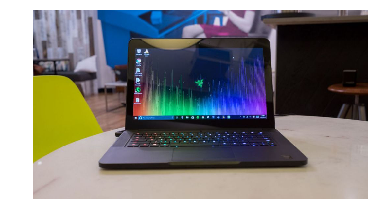

laptop, laptop computer (score = 0.63225)
notebook, notebook computer (score = 0.30791)
screen, CRT screen (score = 0.00507)
mouse, computer mouse (score = 0.00500)
monitor (score = 0.00382)

images/575f86cf7910de92386b403a4c7f7f81.jpg


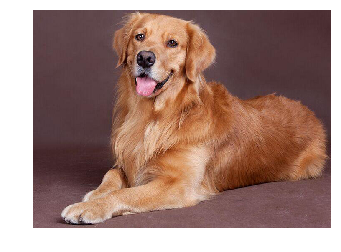

golden retriever (score = 0.91202)
Irish setter, red setter (score = 0.00404)
Labrador retriever (score = 0.00356)
cocker spaniel, English cocker spaniel, cocker (score = 0.00141)
tennis ball (score = 0.00129)

images/5af71b702b4d5e00ccb67d86d9259c86.jpg


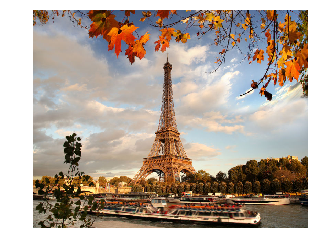

palace (score = 0.33837)
church, church building (score = 0.07487)
fountain (score = 0.06184)
stupa, tope (score = 0.03210)
lakeside, lakeshore (score = 0.02061)

images/feiji.jpg


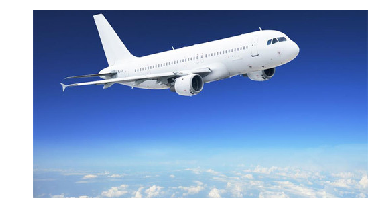

airliner (score = 0.79078)
wing (score = 0.05624)
space shuttle (score = 0.00321)
warplane, military plane (score = 0.00310)
viaduct (score = 0.00081)

images/6eaa9e3458a1a1df96ae96f629b3dc3a.jpg


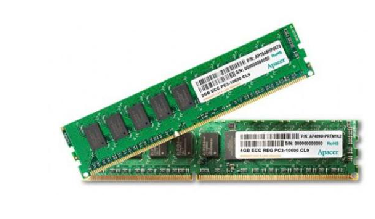

rule, ruler (score = 0.38193)
harmonica, mouth organ, harp, mouth harp (score = 0.28837)
modem (score = 0.08160)
hard disc, hard disk, fixed disk (score = 0.04300)
broom (score = 0.00540)

images/meinv.jpg


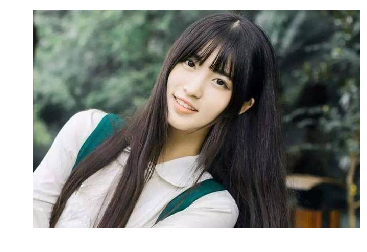

wig (score = 0.38799)
bikini, two-piece (score = 0.13975)
stole (score = 0.07444)
maillot (score = 0.06776)
miniskirt, mini (score = 0.04620)

images/qiche.jpg


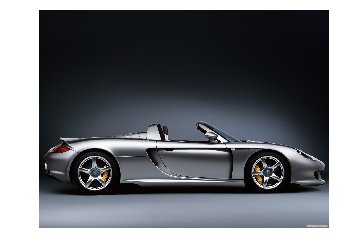

convertible (score = 0.35674)
sports car, sport car (score = 0.27712)
car wheel (score = 0.06452)
racer, race car, racing car (score = 0.04145)
grille, radiator grille (score = 0.00681)



In [17]:
# 建立一个图,存放google训练好的模型
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')
    
with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    
    for root,dirs,files in os.walk('images/'):
        for file in files:
            # 载入图片
            image_data = tf.gfile.FastGFile(os.path.join(root,file), 'rb').read()
            predictions = sess.run(softmax_tensor, {'DecodeJpeg/contents:0':image_data})# 图片为jpg格式
            predictions = np.squeeze(predictions)# 把结果转为1维数据
            
            # 打印图片路径及名称
            img_path = os.path.join(root,file)
            print(img_path)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            
            # 预测结果为每一个类别的概率值,生序排列, 进行降序排列, 并取top5
            top_k = predictions.argsort()[-5:][::-1]
            node_lookup = NodeLookup()
            
            for node_id in top_k:
                human_string = node_lookup.id_to_string(node_id)
                score = predictions[node_id]
                print('%s (score = %.5f)'%(human_string, score))
            print()